You can access our google colab implementation here: https://colab.research.google.com/drive/1Ug--7IRO1ZplbTHfDzMC873Z_iFDL3Cv?usp=sharing

**You have to use .iit.edu email id and use google chrome browser. Otherwise files may not get uploaded.**

In [1]:
# Install mtcnn
!pip install mtcnn

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

Upload these two files present in the data folder: 'data.npy' and 'target.npy'.
data.npy is a large file and it might take about 7-10 minutes.

In [4]:
from google.colab import files
uploaded = files.upload()

Saving data.npy to data.npy
Saving target.npy to target.npy


(4072, 100, 100, 3) (4072, 3)


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


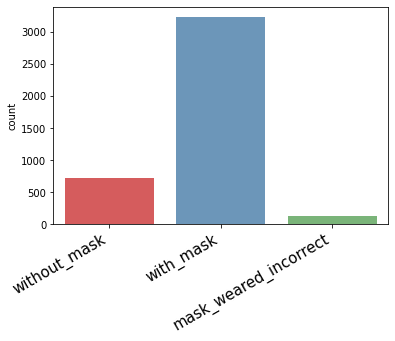

In [6]:
cat_label = {0 : 'without_mask', 1 : 'with_mask', 2 : 'mask_weared_incorrect'}
data = np.load('/content/data.npy')
target = np.load('/content/target.npy')
print(data.shape, target.shape)

ax = sns.countplot(np.argmax(target, axis=1), palette="Set1", alpha=0.8)
ax.set_xticklabels(['without_mask', 'with_mask', 'mask_weared_incorrect'], rotation=30, ha="right", fontsize=15)
plt.show()

**Building model using InceptionV3**

In [7]:
pre_trained_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(100, 100, 3))
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 49, 49, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 49, 49, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 49, 49, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [8]:
for layer in pre_trained_model.layers:
    layer.trainable = False
    
last_layer = pre_trained_model.get_layer('mixed7')
print('Last layer output shape :', last_layer.output_shape)
last_output = last_layer.output

Last layer output shape : (None, 4, 4, 768)


In [9]:
x = tf.keras.layers.Flatten()(last_output)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(3, activation='softmax')(x)

model = tf.keras.models.Model(inputs=pre_trained_model.input, outputs=x)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 49, 49, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 49, 49, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 49, 49, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [10]:
data = data / 255.

X_train, X_test, Y_train, Y_test = train_test_split(data, target, test_size=0.1)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath='model-{epoch:03d}.ckpt', save_weights_only=True, monitor='val_acc', 
    mode='max', save_best_only=True, verbose=0)


history = model.fit(X_train, Y_train, epochs=20, callbacks=[cp_callback], validation_split=0.1)

Epoch 1/20
104/104 [==============================] - 4s 37ms/step - loss: 0.3802 - acc: 0.9187 - val_loss: 0.2109 - val_acc: 0.9537
Epoch 2/20
104/104 [==============================] - 2s 24ms/step - loss: 0.2091 - acc: 0.9484 - val_loss: 0.1258 - val_acc: 0.9619
Epoch 3/20
104/104 [==============================] - 2s 19ms/step - loss: 0.1185 - acc: 0.9724 - val_loss: 0.2473 - val_acc: 0.9264
Epoch 4/20
104/104 [==============================] - 2s 24ms/step - loss: 0.0837 - acc: 0.9739 - val_loss: 0.1186 - val_acc: 0.9700
Epoch 5/20
104/104 [==============================] - 2s 19ms/step - loss: 0.0642 - acc: 0.9821 - val_loss: 0.1464 - val_acc: 0.9564
Epoch 6/20
104/104 [==============================] - 2s 19ms/step - loss: 0.0606 - acc: 0.9864 - val_loss: 0.2192 - val_acc: 0.9537
Epoch 7/20
104/104 [==============================] - 2s 19ms/step - loss: 0.0305 - acc: 0.9909 - val_loss: 0.1584 - val_acc: 0.9619
Epoch 8/20
104/104 [==============================] - 2s 23ms/step - 

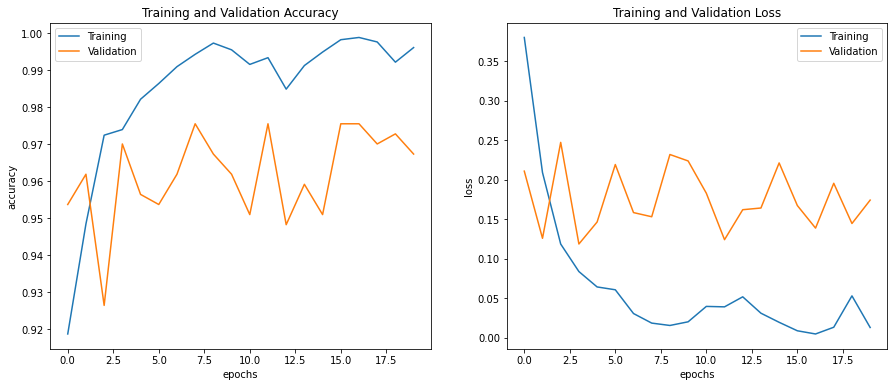

In [11]:
# PLOT LOSS AND ACCURACY
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(15, 6))
plt.subplot(121)
plt.plot(acc, label='Training')
plt.plot(val_acc, label='Validation')
plt.title('Training and Validation Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.subplot(122)
plt.plot(loss, label='Training')
plt.plot(val_loss, label='Validation')
plt.title('Training and Validation Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

13/13 [==============================] - 0s 35ms/step - loss: 0.1454 - acc: 0.9779


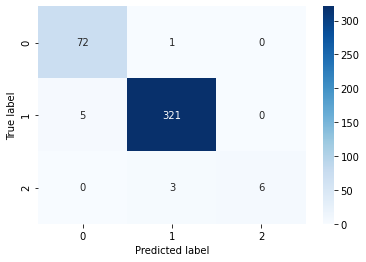

In [12]:
model.evaluate(X_test, Y_test)

Y_pred = np.argmax(model.predict(X_test), axis=1)
Y_test = np.argmax(Y_test, axis=1)

sns.heatmap(confusion_matrix(Y_test, Y_pred), annot=True, fmt='g', cmap=plt.cm.Blues)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

**Face Mask Detection**

In [13]:
import numpy as np
import cv2
from mtcnn.mtcnn import MTCNN
from tensorflow.keras.models import load_model

In [14]:
img_size = (100, 100)
colors = {0: (0, 0, 255), 1: (0, 255, 0), 2: (0, 255, 255)}
cat_label

{0: 'without_mask', 1: 'with_mask', 2: 'mask_weared_incorrect'}

In [15]:
from google.colab.patches import cv2_imshow     # For google colab

def face_mask_detection(imagePath):
  detector = MTCNN()
  frame = cv2.imread(imagePath)
  rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
  faces = detector.detect_faces(rgb)

  for face in faces:
    try:
        x, y, w, h = face['box'] 
        
        # Predict
        roi =  rgb[y : y+h, x : x+w]
        img = cv2.resize(roi, img_size)
        img = img / 255.
        img = img.reshape((1,) + img.shape)
        scores = model.predict(img)
        target = np.argmax(scores, axis=1)[0]

        # Draw bounding boxes
        cv2.rectangle(img=frame, pt1=(x, y), pt2=(x+w, y+h), color=colors[target], thickness=2)
        text = "{}: {:.2f}".format(cat_label[target], scores[0][target])
        cv2.putText(frame, text, (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)

    except Exception as e:
        print(e)
        print(roi.shape)

  # Show the frame
  cv2_imshow(frame)

We have shared the google drive with you. You need to use an .iit.edu mail address to access the data. Here is the link to the data: https://drive.google.com/drive/folders/1MI7GsPA2SU5dZma2IRaxVQXj2KUIf3Yv?usp=sharing **OR** you can use the images in the data folder.

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
image1 = '/content/drive/MyDrive/Face Mask Detection/images/maksssksksss105.png'
image2 = '/content/drive/MyDrive/Face Mask Detection/images/maksssksksss96.png'

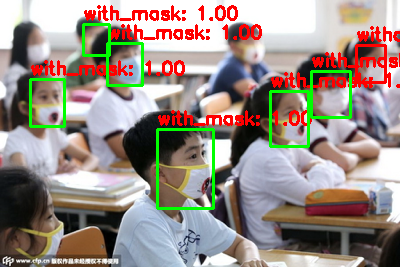

In [18]:
face_mask_detection(image1)

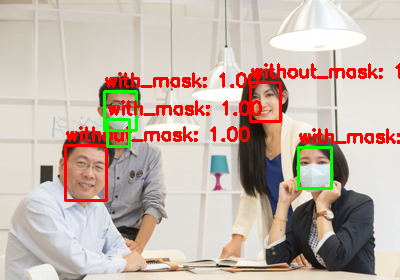

In [19]:
face_mask_detection(image2)